# LangGraph (LangChain + Graph)

- It’s a framework to build stateful, multi-step AI applications using graphs. 
- Creating flows (like a diagram) for how your AI app should behave — what should happen first, then what next, and so on.

Langgraph:
Nodes - Edges - State

Node Implementaiton > Transcript
Edges
State > Variable

Graph API - Functional API

In [38]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages # reducer: add message

In [39]:
class State(TypedDict):
    messages:Annotated[list,add_messages] # reducer: not replacing but append

In [40]:
# build Graph
graph_builder = StateGraph(State)

In [41]:
graph_builder

In [42]:
# load env
import os
from dotenv import load_dotenv
load_dotenv()

True

In [43]:
from langchain_groq import ChatGroq
# from langchain.chat_models import init_chat_model

llm  = ChatGroq(model="llama3-8b-8192")
# llm = init_chat_model("groq:llama3-8b-8192")

In [44]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000021F5B3C6310>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021F5B3C5990>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [45]:
# Node
def chatbot(state:State):
    return {
        "messages": [llm.invoke(state["messages"])]
    }

In [46]:
graph_builder = StateGraph(State)

node = "llmchatbot"

graph_builder.add_node(node, chatbot) 

graph_builder.add_edge(START,node)
graph_builder.add_edge(node,END)

# Compile
graph=graph_builder.compile()

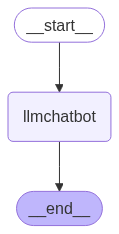

In [47]:
# Visualize
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [48]:
response = graph.invoke({"messages":"Hello World"})

In [49]:
response["messages"]

[HumanMessage(content='Hello World', additional_kwargs={}, response_metadata={}, id='11643859-86b9-438f-8363-94657f4b7649'),
 AIMessage(content='Hello World!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 12, 'total_tokens': 16, 'completion_time': 0.008861341, 'prompt_time': 0.006459605, 'queue_time': 10.233362326, 'total_time': 0.015320946}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--26f71fb3-e7ec-484e-977f-94e76091ebbb-0', usage_metadata={'input_tokens': 12, 'output_tokens': 4, 'total_tokens': 16})]

In [50]:
response["messages"][-1].content

'Hello World!'

In [51]:
for event in graph.stream({"messages":"Whats the capital of Nepal?"}):
    for value in event.values():
        print(value["messages"][-1].content)

The capital of Nepal is Kathmandu.


## Tools

In [97]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results = 2)
tool.invoke("What is current news about US and Iran")

{'query': 'What is current news about US and Iran',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "Live updates: Iranian leader warns US of 'irreparable damage' | AP News",
   'url': 'https://apnews.com/live/israel-iran-attack-conflict-updates',
   'content': "Iran says it will keep enriching uranium: Israel says it launched the strikes to prevent Iran from building a nuclear weapon, after talks between the United States and Iran over a diplomatic resolution had made little visible progress over two months but were still ongoing. Trump has said Israel's campaign came after a 60-day window he set",
   'score': 0.66777676,
   'raw_content': None},
  {'title': 'Israel and Iran trade strikes as Trump weighs US involvement in conflict',
   'url': 'https://www.cnn.com/world/live-news/israel-iran-conflict-06-19-25-intl-hnk',
   'content': "Iran and Israel continue to trade strikes as President Donald Trump's decision on whether the US would get involved 

In [53]:
# custom 

def multiply(a:int, b:int)->int:
    """
    Multiply two numbers.
    
    Args:
        a (int): first int
        b (int): second int
    
    Returns:
        int: output int
    """
    return a*b

In [54]:
c = multiply(10,4)
c

40

In [55]:
tools = [tool, multiply]
llm_with_tool = llm.bind_tools(tools)

In [98]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000021F5B3C6310>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021F5B3C5990>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

In [99]:

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
def tool_calling_llm(state:State):
    return {
        "messages":[llm_with_tool.invoke(state["messages"])]
    }

In [110]:
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)

builder.add_edge("tools", "tool_calling_llm") # change
# builder.add_edge("tools", END) # change

graph = builder.compile()

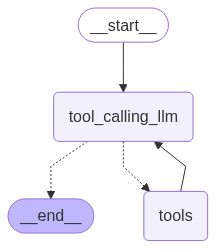

In [111]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [102]:
graph.invoke({"messages":"What is the recent WAR news about Iran and Israel"})

{'messages': [HumanMessage(content='What is the recent WAR news about Iran and Israel', additional_kwargs={}, response_metadata={}, id='63b189ae-22e0-42c1-ae23-868fbd0d748d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fhm4vfhtz', 'function': {'arguments': '{"exclude_domains":["twitter.com"],"include_domains":["aljazeera.com","haaretz.com"],"include_images":true,"query":"recent WAR news about Iran and Israel","search_depth":"advanced","time_range":"week","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 225, 'prompt_tokens': 2197, 'total_tokens': 2422, 'completion_time': 0.643204474, 'prompt_time': 0.360669561, 'queue_time': 1.146862827, 'total_time': 1.003874035}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9ffe12d6-37ac-48d9-8010-bbd866939844-0', tool_calls=[{'name': 'tavily_search', 'args': {'exclude_dom

In [103]:
response = graph.invoke({"messages":"What is the recent WAR news about Iran and Israel"})
response["messages"]

[HumanMessage(content='What is the recent WAR news about Iran and Israel', additional_kwargs={}, response_metadata={}, id='5e296dde-b217-41cc-8991-81f2146fb46e'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'btds113kf', 'function': {'arguments': '{"exclude_domains":[],"include_domains":[],"include_images":false,"query":"recent WAR news about Iran and Israel","search_depth":"advanced","time_range":null,"topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 115, 'prompt_tokens': 2197, 'total_tokens': 2312, 'completion_time': 0.319857755, 'prompt_time': 1.356388687, 'queue_time': 7.972554746999999, 'total_time': 1.676246442}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6f213104-28b2-487f-8c2b-be875bd783a8-0', tool_calls=[{'name': 'tavily_search', 'args': {'exclude_domains': [], 'include_domains': [], 'include_images':

In [104]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent WAR news about Iran and Israel
================================== Ai Message ==================================
Tool Calls:
  tavily_search (btds113kf)
 Call ID: btds113kf
  Args:
    exclude_domains: []
    include_domains: []
    include_images: False
    query: recent WAR news about Iran and Israel
    search_depth: advanced
    time_range: None
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent WAR news about Iran and Israel", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.twz.com/news-features/one-third-of-irans-long-range-missile-launchers-destroyed-israel-claims", "title": "One Third Of Iran’s Long-Range Missile Launchers Destroyed, Israel Claims - The War Zone", "score": 0.77261686, "published_date": "Mon, 16 Jun 2025 18:23:35 GMT", "content": "Iran a

In [105]:
response = graph.invoke({"messages":"What is 10 multiplied by 4"})

In [106]:
response

{'messages': [HumanMessage(content='What is 10 multiplied by 4', additional_kwargs={}, response_metadata={}, id='a66567ef-a0ff-415d-a555-146a2c2ea419'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8g1048gsr', 'function': {'arguments': '{"a":10,"b":4}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 2195, 'total_tokens': 2267, 'completion_time': 0.209671859, 'prompt_time': 0.254635105, 'queue_time': 3.0040050230000004, 'total_time': 0.464306964}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--675e3ab1-0653-4981-b86f-067adadf0245-0', tool_calls=[{'name': 'multiply', 'args': {'a': 10, 'b': 4}, 'id': '8g1048gsr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2195, 'output_tokens': 72, 'total_tokens': 2267}),
  ToolMessage(content='40', name='multiply', id='93de9c4b-8cd0-4695-a4a2-066701f2a611', tool_call_

In [107]:
# Act Observe Reason: ReACT
graph.invoke({"messages":"Provide me weather prediction of Kathmandu and multiply 4 by 6"})

{'messages': [HumanMessage(content='Provide me weather prediction of Kathmandu and multiply 4 by 6', additional_kwargs={}, response_metadata={}, id='8ddce81d-b526-40e9-9c8f-3954735d6e58'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'qjktkasds', 'function': {'arguments': '{"query":"weather Kathmandu","search_depth":"advanced","time_range":"day","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': '689jtb2pd', 'function': {'arguments': '{"a":4,"b":6}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 147, 'prompt_tokens': 2202, 'total_tokens': 2349, 'completion_time': 0.300736113, 'prompt_time': 0.27632224, 'queue_time': 0.8668759719999999, 'total_time': 0.577058353}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f694be91-9d18-4855-b118-82af6056050e-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'we

In [108]:
response

{'messages': [HumanMessage(content='What is 10 multiplied by 4', additional_kwargs={}, response_metadata={}, id='a66567ef-a0ff-415d-a555-146a2c2ea419'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8g1048gsr', 'function': {'arguments': '{"a":10,"b":4}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 2195, 'total_tokens': 2267, 'completion_time': 0.209671859, 'prompt_time': 0.254635105, 'queue_time': 3.0040050230000004, 'total_time': 0.464306964}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--675e3ab1-0653-4981-b86f-067adadf0245-0', tool_calls=[{'name': 'multiply', 'args': {'a': 10, 'b': 4}, 'id': '8g1048gsr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2195, 'output_tokens': 72, 'total_tokens': 2267}),
  ToolMessage(content='40', name='multiply', id='93de9c4b-8cd0-4695-a4a2-066701f2a611', tool_call_

In [109]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 10 multiplied by 4
================================== Ai Message ==================================
Tool Calls:
  multiply (8g1048gsr)
 Call ID: 8g1048gsr
  Args:
    a: 10
    b: 4
================================= Tool Message =================================
Name: multiply

40


In [ ]:
response=graph.invoke({"messages":"What is the value of currency NPR with $ find and multiply both amount"})

In [121]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the value of currency NPR with $ find and multiply both amount
================================== Ai Message ==================================

/tool-use>
{
    "tool_calls": [
        {
            "id": "pending",
            "type": "function",
            "function": {
                "name": "multiply"
            },
            "parameters": {
                "a": 1,
                "b": 100
            }
        }
    ]
}
</tool-use>

Please note that NPR is not a currency code recognized by the tool, so I've assumed it's the Nepalese Rupee. The tool will perform the multiplication operation on the given amounts.


In [125]:
response=graph.invoke({"messages":"Who is the current CEO of google? and multiply 10 with 3"})

In [126]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Who is the current CEO of google? and multiply 10 with 3
================================== Ai Message ==================================
Tool Calls:
  tavily_search (cjhwtan0n)
 Call ID: cjhwtan0n
  Args:
    query: Who is the current CEO of Google?
  multiply (8s7762778)
 Call ID: 8s7762778
  Args:
    a: 10
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "Who is the current CEO of Google?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Google CEO and Key Executive Team | Craft.co", "url": "https://craft.co/google/executives", "content": "Google's CEO is Sundar Pichai. Other executives include Philipp Schindler, Senior Vice President and Chief Business Officer; Lorraine Twohill, Chief Marketing Officer and 17 others. See the full leadership team at Craft.", "score": 0.8893851, "raw_content": null

## Memory

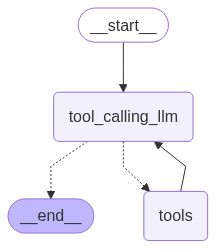

In [127]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [128]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"I'm from country Nepal."},config=config)

response

{'messages': [HumanMessage(content="I'm from country Nepal.", additional_kwargs={}, response_metadata={}, id='cf00f136-9cf1-457c-94f0-93049e9b69ef'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 's830zpnwx', 'function': {'arguments': '{"query":"Nepal"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 2193, 'total_tokens': 2263, 'completion_time': 0.147803384, 'prompt_time': 0.496113784, 'queue_time': 5.9137143409999995, 'total_time': 0.643917168}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--187ee420-a6c7-47cc-8b6a-d4268813df13-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Nepal'}, 'id': 's830zpnwx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2193, 'output_tokens': 70, 'total_tokens': 2263}),
  ToolMessage(content='{"query": "Nepal", "follow_up_questions": null, "answer": null, 

In [129]:
response=graph.invoke({"messages":"Do you know where do i belong"},config=config)

print(response['messages'][-1].content)

I think I can help you with that!

According to the tool call results I obtained earlier, you are from Nepal, a country located in South Asia.


In [130]:
response=graph.invoke({"messages":"Good, wht do you know more about my country"},config=config)
print(response['messages'][-1].content)


I can tell you more about Nepal!


## Human in the Loop HITL

In [132]:
from langgraph.graph import StateGraph, START, END

class HITLState:
    message: str
    needs_human: bool
    response: str

In [134]:
# Node: LLM processes the message
def llm_node(state: HITLState):
    # Simulate LLM: flag messages containing "review" for human
    needs_human = "review" in state["message"].lower()
    return {
        "message": state["message"],
        "needs_human": needs_human,
        "response": f"LLM processed: {state['message']}"
    }

# Node: Human review node
def human_node(state: HITLState):
    # Simulate human intervention
    return {
        "message": state["message"],
        "needs_human": False,
        "response": f"Human reviewed: {state['message']}"
    }

# Conditional edge function
def needs_human_condition(state: HITLState):
    return "human" if state["needs_human"] else END

# Build the graph
graph = StateGraph(HITLState)
graph.add_node("llm", llm_node)
graph.add_node("human", human_node)
graph.add_edge(START, "llm")
graph.add_conditional_edges("llm", needs_human_condition, {"human": "human", END: END})
graph.add_edge("human", END)
compiled_graph = graph.compile()

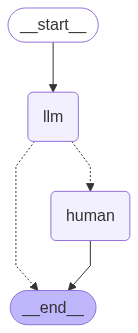

In [135]:
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [137]:
# Example 1: No human needed
result1 = compiled_graph.invoke({"messages": "Say hello", "needs_human": False, "response": ""})
print(result1["response"])

TypeError: HITLState() takes no arguments

In [ ]:

# Example 2: Human in the loop triggered
result2 = compiled_graph.invoke({"message": "Please review this", "needs_human": False, "response": ""})
print(result2["response"])